Improvements comparing previous script (toy model and fashion - MNIST) :
- when a new dimension is added, it is chosen randomly within the orthogonal space of the current singular vectors, with a random singular value whose esperancy is half the smallest singular value
- when dimensions are suppressed, a projection is performed on the remaining space (instead of simply keep the weights of the remaining dimensions).

In [1]:
from datetime import datetime
import os, pickle

import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor

from torchinfo import summary

In [2]:
dataset_path = os.path.realpath('D:\\Python\\DL_test\\datasets')


training_data = datasets.CIFAR10(
    root=dataset_path,
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.CIFAR10(
    root=dataset_path,
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape, X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

Files already downloaded and verified
Files already downloaded and verified
Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32]) torch.float32
Shape of y:  torch.Size([64]) torch.int64


In [ ]:
path = "D:\\Python\\DL_test\\Evol_NN\\bckup"
model_name = "resnet18"

if f"{model_name}_params.pt" in os.listdir(path):
    model = models.resnet18()
    model.load_state_dict(torch.load(os.path.join(path, f"{model_name}_params.pt")))
else:
    model = models.resnet18(pretrained=True)
    torch.save(model.state_dict(), os.path.join(path, f"{model_name}_params.pt"))

print(model)

print(summary(model, input_size=X.shape, row_settings =("depth", "var_names"),depth=6))


In [21]:
class ModelsMgmt():
    def load(self, model, device, path, model_name):

        try:
            with open(os.path.join(path, f"{model_name}_layers_dict_in.pk"), "rb") as f:
                layers_dict_in = pickle.load(f)
        except:
            print('unable to load layers_dict')

        model.__init__(layers_dict_in)
        model.load_state_dict(torch.load(os.path.join(path, f"{model_name}_params.pt")))
        
        try:
            model.historique = pd.read_excel(os.path.join(path, f"{model_name}_historique.xlsx"), index_col=0)
        except:
            print('unable to load historique')
            
        model.to(device)
        
        return
    
    def save(self, model, path, model_name):
        
        if not os.path.exists(path):
            os.makedirs(path)
        with open(os.path.join(path, f"{model_name}_layers_dict_in.pk"), "wb") as f:
            pickle.dump(model.layers_dict_in, f)      
            
        torch.save(model.state_dict(), os.path.join(path, f"{model_name}_params.pt"))
        
        if len(model.historique)!=0:
            model.historique.to_excel(os.path.join(path, f"{model_name}_historique.xlsx"))
        return
    
    def analyze(self, model):
        blocks = [key for key in model.state_dict()
                 if key.split('.')[-1] == 'weight']
        columns = ["dims", "sum_s"]
        columns += [f"s_{i}" for i in range(512)]
        composition = pd.DataFrame(columns=columns, index=blocks).astype('object')
        curr_block = ""
        layer_in_block = 0
        new_state_dict = {}
        evol_dim_in=0
        for param_tensor in model.state_dict():
            if param_tensor[-6:]=="weight" :
                print(f"curr_layer : {param_tensor}")
                weight = model.state_dict()[param_tensor]
                print(f"weight.shape : {weight.shape}")
                if len(weight.shape) > 1:
                    u, s, vh = get_usvh(weight)
                    for i in range(min(512, s.shape[0])):
                        composition.at[param_tensor, f"s_{i}"] = s[i].numpy()
                    composition.at[param_tensor, "sum_s"] = torch.sum(s).numpy()
                else:
                    for i in range(min(512, weight.shape[0])):
                        composition.at[param_tensor, f"s_{i}"] = weight[i].numpy()
                    composition.at[param_tensor, "sum_s"] = torch.sum(weight).numpy()
                composition.at[param_tensor, "dims"] = list(weight.shape)

        return composition
    
    def optimize_layers(self, model, device, tresh_prun, tresh_add, flatten_size, u_r=None):
        '''Pseudocode : 
        On balaye les couches. 
        Lorsque s[-1]/energy est inférieur à treshold_inf, diminue la sortie de 1.
        Lorsque s[-1]/energy est supérieur à treshold_sup, on augmente la sortie de 1.
        On sauve et on actualise l'historique
        '''
        blocks = [key.split('.')[-2] for key in model.state_dict()
                 if key.split('.')[-1] == 'weight']
        if len(model.historique) == 0:
            columns = [f"{block}_s" for block in blocks]
            columns += [f"{block}_dims" for block in blocks]
            model.historique = pd.DataFrame(columns=columns).astype('object')
        curr_idx = datetime.now().strftime("%y-%m-%d-%H:%M:%S")
        model.historique.append(pd.Series(name=curr_idx, dtype='object'))
        curr_block = ""
        layer_in_block = 0
        new_state_dict = {}
        evol_dim_in=0
        for param_tensor in model.state_dict():
            if param_tensor[-6:]=="weight" :
                layer_tree = param_tensor.split(".")
                block = layer_tree[1]
                curr_layer = layer_tree[-2]
                print(f"curr_layer : {curr_layer}")
                if block == curr_block:
                    layer_in_block += 1
                else:
                    layer_in_block = 0
                    curr_block = block
                weight = model.state_dict()[param_tensor]
                if len(weight.shape)==4:
                    in_step = 1
                else:
                    in_step = flatten_size**2
                print(f"debug : {flatten_size}{len(weight.shape)}{evol_dim_in}")
                # if evol_dim_in <0, reduce input size of weight
                if evol_dim_in <0:
                    if len(weight.shape)==4:
                        weight = torch.einsum('echw,cd->edhw', weight, u_r)
                    else:
                        weight = torch.reshape(weight, (weight.shape[0], int(weight.shape[1]/in_step), 
                                                        flatten_size, flatten_size))
                        weight = torch.einsum('echw,cd->edhw', weight, u_r)
                        weight = torch.reshape(weight, (weight.shape[0], weight.shape[1]*weight.shape[2]*weight.shape[3]))
                u, s, vh = get_usvh(weight)
                model.historique.at[curr_idx, f"{curr_layer}_s"] = str(s.tolist())
                model.historique.at[curr_idx, f"{curr_layer}_dims"] = str(weight.shape[:2])

                if evol_dim_in <0:
                    print(f"réduire d_in de {evol_dim_in * in_step}")
                elif evol_dim_in > 0:
                    print(f"augmenter d_in de {evol_dim_in * in_step}")
                model.layers_dict_in[block]["dims"][layer_in_block] = weight.shape[1] + in_step * max(0, evol_dim_in)
#                 print(f"debug : {model.layers_dict_in[block]['dims'][layer_in_block]}")

                energy = torch.sum(s)
                print(f"s[-1] * weight.shape[0] / energy : {s[-1]*weight.shape[0]/energy}")
                if (s[-1] < tresh_prun*energy/weight.shape[0]) and (curr_layer != blocks[-1]):
                    i = 1
                    while torch.sum(s[-i-1:]) < tresh_prun*energy:
                        i += 1
                    print(f"réduire d_out de {i}")
                    evol_dim_out = -i
                elif (s[-1] > tresh_add*energy/weight.shape[0]) and (curr_layer != blocks[-1]):
#                     print("augmenter d_out de 1")
                    evol_dim_out = 1
                else:
                    evol_dim_out = 0
                
                # update wieghts and bias
                param_bias = param_tensor[:-6]+"bias"
                bias = model.state_dict()[param_bias]
                if evol_dim_in != 0 or evol_dim_out != 0 :
                    weight, evol_dim_in, evol_dim_out, u_r = update_weight(m=weight, u=u, s=s, vh=vh, 
                                                                           evol_dim_in=evol_dim_in * in_step, u_r=u_r, 
                                                                           evol_dim_out=evol_dim_out, device=device)
                    bias = update_bias(bias=bias, evol_dim_out=evol_dim_out, u_r=u_r, device=device)
                
                    print(f"evol_dim_out : {evol_dim_out}")
                new_state_dict[param_tensor] = weight
                new_state_dict[param_bias] = bias
                
                model.layers_dict_in[block]["dims"][layer_in_block + 1] += evol_dim_out
#                 print(f"debug : {model.layers_dict_in[block]['dims'][layer_in_block+1]}")
                
                evol_dim_in = evol_dim_out
            else:
                if param_tensor not in new_state_dict.keys():
                    new_state_dict[param_tensor] = model.state_dict[param_tensor]


        generic_name = "tmp"
        model.layers_dict = nn.ModuleDict({name: value["fun"](*value["dims"], name) 
                                          for name, value in model.layers_dict_in.items()})
        model.load_state_dict(new_state_dict)
        self.save(model, "D:\\Python\\DL_test\\DL_tests\\bckup", f"{generic_name}")
        self.load(model, device, "D:\\Python\\DL_test\\DL_tests\\bckup", f"{generic_name}")
        print(f"layers_dict_in : {model.layers_dict_in}")

        return model

    

In [ ]:
composition = ModelsMgmt().analyze(model)

composition.to_excel("resnet18_compo.xlsx")

In [4]:
class TestNN(nn.Module):
    def __init__(self, layers_dict):
        super().__init__()
        self.layers_dict_in = layers_dict
        self.layers_dict = nn.ModuleDict({name: value["fun"](*value["dims"], name) 
                                          for name, value in self.layers_dict_in.items()})
        self.historique = pd.DataFrame()
            
        return
        
    def forward(self, x):
        for _, layer in self.layers_dict.items():
            x = layer(x)
        return x


In [5]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_inter, dim_out, nom):
        super(ResBlock, self).__init__()
        self.dim_out = dim_out
#         
        self.repeat = int(np.ceil(dim_out/dim_in))
        self.layers_dict = nn.ModuleDict({
            f"{nom}_activation_0": nn.LeakyReLU(negative_slope=0.1, inplace=False),
            f"{nom}_conv2d_0": nn.Conv2d(in_channels=dim_in, out_channels=dim_inter, kernel_size=3, 
                      stride=1, padding=1, dilation=1, groups=1, bias=True, 
                      padding_mode='zeros'), 
#             f"{nom}_dropout_0": nn.Dropout(p=0.1, inplace=False),
            f"{nom}_activation_1": nn.LeakyReLU(negative_slope=0.1, inplace=False),
            f"{nom}_conv2d_1": nn.Conv2d(in_channels=dim_inter, out_channels=dim_out, kernel_size=3, 
                      stride=1, padding=1, dilation=1, groups=1, bias=True, 
                      padding_mode='zeros'), 
#             f"{nom}_dropout_1": nn.Dropout(p=0.1, inplace=False),
            })

        return
    
    def forward(self, x):
        input = torch.tile(x=x, dims=(1, self.repeat, 1, 1))
        input = input[:, :self.dim_out, :, :]
        for _, layer in self.layers_dict.items():
#             print(f"x.shape : {x.shape}")
            x = layer(x)
#         print(f"input.shape : {input.shape}")
#         print(f"x.shape : {x.shape}")
        x = (input + x)
#         x = nn.LeakyReLU(negative_slope=0.1, inplace=False)(x)
        return x


class DenseBlock(nn.Module):
    def __init__(self, dim_in, dim_out, nom):
        super(DenseBlock, self).__init__()
        self.layers_dict = nn.ModuleDict({
            f"{nom}_activation_0": nn.LeakyReLU(negative_slope=0.1, inplace=False),
            f"{nom}_Flatten": nn.Flatten(), 
            f"{nom}_Dense": nn.Linear(dim_in, dim_out),
            })

        return
    
    def forward(self, x):
        for _, layer in self.layers_dict.items():
#             print(f"x.shape : {x.shape}")
            x = layer(x)
#         x = nn.functional.log_softmax(x, dim=1)
        return x

    
class DownscaleBlock(nn.Module):
    def __init__(self, nom):
        super(DownscaleBlock, self).__init__()
        self.layers_dict = nn.ModuleDict({
            f"{nom}_MaxPool2d": nn.MaxPool2d(kernel_size=2, stride=2, 
                                  padding=0, dilation=1),
            })
        return
    
    def forward(self, x):
        for _, layer in self.layers_dict.items():
            x = layer(x)
        return x

In [45]:
def get_usvh(m):
    if len(m.shape)==4:
        # Format d_out * d_in ou ch_out * ch_in * h * w
        # la dimension coupée doit être la première du reshape/slice
        a = m.reshape(m.shape[0], m.shape[1]*m.shape[2]*m.shape[3])
        d_in = m.shape[1]*m.shape[2]*m.shape[3]
        d_out = m.shape[0]

    elif len(m.shape)==2:
        a = m
        d_in = m.shape[1]
        d_out = m.shape[0]

    u, s, vh = torch.linalg.svd(a, full_matrices=False)
    print(f"s : {s[0]}...{s[-1]}, s.shape : {s.shape}")

#     usvh = u @ torch.diag(s) @ vh

#     if len(m.shape)==4:
#         usvh = usvh.reshape(m.shape[0], m.shape[1], m.shape[2], m.shape[3])

    return u, s, vh

def update_weight(m, u, s, vh, u_r, evol_dim_in, evol_dim_out, device):
    
    if len(m.shape)==4:
        step = m.shape[2]*m.shape[3]
    else:
        step = 1

    d_in = m.shape[1]
    d_out = m.shape[0]
    
    # contrôle de la taille des matrices
    # d_in : contrôle inutile car d_out contrôlé au layer précédent
    if evol_dim_in < 0:
        evol_dim_in = 0
    if d_out + evol_dim_out == 0:
        evol_dim_out = 0        
    if (d_in + evol_dim_in)*step < d_out + evol_dim_out:
        evol_dim_out = (d_in + evol_dim_in)*step - d_out
        
    # modif des poids (evol_dim_in<0 déjà pris en compte)

    if evol_dim_in > 0:
        vh_ = torch.randn(d_out, (d_in + evol_dim_in) * step, device=device) / (d_in + evol_dim_in) / step
        vh_[:d_out, :d_in*step] = vh
        vh = vh_
        
    if evol_dim_out < 0:
        u_r = u[evol_dim_out:, :evol_dim_out]
        u = u[:evol_dim_out, :evol_dim_out]
        u_r = u_r @ u.t()
        u_r = torch.cat((torch.eye(d_out + evol_dim_out, device=device), u_r), 0)
        s = s[:evol_dim_out]
        vh = vh[:evol_dim_out, :]
    elif evol_dim_out > 0:
        u_ = torch.diag(torch.randn(d_out + evol_dim_out, device=device))/(d_out + evol_dim_out)
        u_[:d_out, :d_out] = u
        u = u_
        s_ = s[-1] * torch.randn(d_out + evol_dim_out, device=device)/2
        s_[:d_out] = s      
        s = s_
        for i in range(evol_dim_out):
            X = torch.randn((d_in + evol_dim_in) * step, device=device)
            e_k = X @ vh.t() @ vh
            e_k = X - e_k
            e_k /= torch.linalg.vector_norm(e_k)
            print(f"debug : {vh.shape}, {e_k.reshape(-1, 1).shape}")
            vh = torch.cat((vh, e_k.reshape(1, -1)), dim=0)

    usvh = u @ torch.diag(s) @ vh
    
#     print(f"debug : {m.shape}, {u.shape}, {s.shape}, {vh.shape}, {evol_dim_in}, {evol_dim_out}")

    if len(m.shape)==4:
        usvh = usvh.reshape(m.shape[0] + evol_dim_out, m.shape[1] + evol_dim_in, m.shape[2], m.shape[3])

    return usvh, evol_dim_in, evol_dim_out, u_r
    
def update_bias(bias, evol_dim_out, u_r, device):
    if evol_dim_out < 0:
#         print(f"bias : {bias}")        
        optim = optimize.lsq_linear(A=u_r.cpu(), b=bias.cpu())
        bias = torch.from_numpy(optim.x).to(device)
#         print(f"optim.x : {optim.x}")
        
    elif evol_dim_out > 0:
        bias_ = torch.randn(bias.shape[0] + evol_dim_out, device=device)
        bias_[:bias.shape[0]] = bias
        bias = bias_
        
    return bias
    
                

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

model_name = "20210802_CIFAR_SVD"
flatten_size = 2
total_epoch = 0

layers_dict = {
    "ResBlock_0" : {"fun": ResBlock, "dims": [3, 15, 50]},
    "ResBlock_1" : {"fun": ResBlock, "dims": [50, 15, 60]},
    "DownscaleBlock_1" : {"fun": DownscaleBlock, "dims": []},
    "ResBlock_2" : {"fun": ResBlock, "dims": [60, 20, 125]},
    "ResBlock_3" : {"fun": ResBlock, "dims": [125, 30, 165]},
    "ResBlock_4" : {"fun": ResBlock, "dims": [165, 60, 200]},
    "DownscaleBlock_2" : {"fun": DownscaleBlock, "dims": []},
    "ResBlock_5" : {"fun": ResBlock, "dims": [200, 135, 200]},
    "ResBlock_6" : {"fun": ResBlock, "dims": [200, 135, 200]},
    "ResBlock_7" : {"fun": ResBlock, "dims": [200, 135, 200]},
    "DownscaleBlock_3" : {"fun": DownscaleBlock, "dims": []},
    "ResBlock_8" : {"fun": ResBlock, "dims": [200, 100, 150]},
    "ResBlock_9" : {"fun": ResBlock, "dims": [150, 100, 150]},
    "DownscaleBlock_4" : {"fun": DownscaleBlock, "dims": []},
    "ResBlock_10" : {"fun": ResBlock, "dims": [150, 50, 125]},
    "ResBlock_11" : {"fun": ResBlock, "dims": [125, 50, 125]},
    "DenseBlock_11" : {"fun": DenseBlock, "dims": [flatten_size*flatten_size*125, 10]},
    }
model = TestNN(layers_dict=layers_dict)
model.to(device)
print(model)

print(summary(model, input_size=X.shape, row_settings =("depth", "var_names"),depth=6))

train_losses = []
test_losses = []


Using cuda device
TestNN(
  (layers_dict): ModuleDict(
    (ResBlock_0): ResBlock(
      (layers_dict): ModuleDict(
        (ResBlock_0_activation_0): LeakyReLU(negative_slope=0.1)
        (ResBlock_0_conv2d_0): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (ResBlock_0_activation_1): LeakyReLU(negative_slope=0.1)
        (ResBlock_0_conv2d_1): Conv2d(15, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (ResBlock_1): ResBlock(
      (layers_dict): ModuleDict(
        (ResBlock_1_activation_0): LeakyReLU(negative_slope=0.1)
        (ResBlock_1_conv2d_0): Conv2d(50, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (ResBlock_1_activation_1): LeakyReLU(negative_slope=0.1)
        (ResBlock_1_conv2d_1): Conv2d(15, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (DownscaleBlock_1): DownscaleBlock(
      (layers_dict): ModuleDict(
        (DownscaleBlock_1_MaxPool2d): MaxPool2d(kernel_size=2, stride=2, pa

2021-08-03 11:13:54.753057 : Epoch : 4
training set accuracy : 0.67636
testing set accuracy : 0.5706
2021-08-03 11:14:57.549103
optimizing layers...
curr_layer : ResBlock_0_conv2d_0
debug : 240
s : 0.7295028567314148...0.07755478471517563, s.shape : torch.Size([17])
s[-1] * weight.shape[0] / energy : 0.2692863643169403
debug : torch.Size([17, 27]), torch.Size([27, 1])
evol_dim_out : 1
curr_layer : ResBlock_0_conv2d_1
debug : 241
s : 0.751646101474762...0.105784572660923, s.shape : torch.Size([44])
augmenter d_in de 1
s[-1] * weight.shape[0] / energy : 0.4211190342903137
debug : torch.Size([44, 162]), torch.Size([162, 1])
evol_dim_out : 1
curr_layer : ResBlock_1_conv2d_0
debug : 241
s : 1.218062400817871...0.20896093547344208, s.shape : torch.Size([15])
augmenter d_in de 1
s[-1] * weight.shape[0] / energy : 0.47780027985572815
debug : torch.Size([15, 405]), torch.Size([405, 1])
evol_dim_out : 1
curr_layer : ResBlock_1_conv2d_1
debug : 241
s : 1.0483437776565552...0.05957835912704468, s.

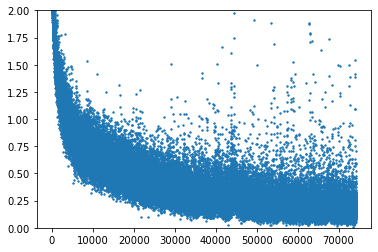

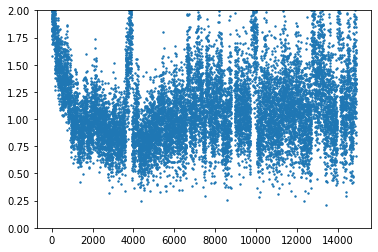

In [46]:
nb_epochs = 90
prev_epoch = total_epoch + 1
optimizer = optim.SGD(model.parameters(), lr=2e-2, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

result = pd.DataFrame(index=["train_acc", "train_loss", "test_acc", "test_loss"])

try:
    len(test_losses)
    len(train_losses)
except:
    train_losses = []
    test_losses = []

for epoch in range(nb_epochs):
    total_epoch = epoch + prev_epoch
    print(f"{datetime.now()} : Epoch : {total_epoch}")
    
    model.train()
    correct_train, target_count = 0, 0
    train_loss = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad() # Clear gradients
        output = model(x) # Forward pass
        loss = criterion(output, y) # Calculate loss

        train_losses.append(loss.item())
        train_loss += loss.item()

        loss.backward() # Backward pass
        optimizer.step() # Optimize weights
        
        # accuracy
        _, predicted = torch.max(output.data, 1)
        target_count += y.size(0)
        correct_train += (y == predicted).sum().item()
    train_acc = (correct_train) / target_count
    train_loss /= target_count
    print(f"training set accuracy : {train_acc}")
        
    model.eval()
    correct_train, target_count = 0, 0
    test_loss = 0
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        output = model(x) # Forward pass
        loss = criterion(output, y) # Calculate loss

        test_losses.append(loss.item())
        test_loss += loss.item()
        # accuracy
        _, predicted = torch.max(output.data, 1)
        target_count += y.size(0)
        correct_train += (y == predicted).sum().item()
    test_acc = (correct_train) / target_count
    test_loss /= target_count
    print(f"testing set accuracy : {test_acc}")
    
    result[total_epoch] = [train_acc, train_loss, test_acc, test_loss]
    
    if (total_epoch > 2) and (total_epoch % 5 == 4):
        print(datetime.now())
        print("optimizing layers...")    
        model = ModelsMgmt().optimize_layers(model, tresh_prun=5e-3, tresh_add=1e-2, 
                                             flatten_size=flatten_size, device=device)
        iter = epoch + prev_epoch
        step = f"{iter}_iters_optim"
        ModelsMgmt().save(model, "D:\\Python\\DL_test\\Evol_NN\\bckup", f"{model_name}_{step}")
        optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

print(summary(model, input_size=X.shape, row_settings =("depth", "var_names"),depth=6))

    
plt.figure()
plt.scatter([x for x in range(len(train_losses))], train_losses, s=2)
plt.ylim(0, 2) 
plt.show()

plt.figure()
plt.scatter([x for x in range(len(test_losses))], test_losses, s=2)
plt.ylim(0, 2) 
plt.show()

In [47]:
with open('20210803_train_losses_mat_cifar_3e_passe.txt', 'w') as f:
    f.write(str(train_losses))
with open('20210803_test_losses_mat_cifar_3e_passe.txt', 'w') as f:
    f.write(str(test_losses))
result.to_excel("20210803_mat_cifar_3e_passe.xlsx")

In [ ]:
CUDA_LAUNCH_BLOCKING=1
total_epoch = 49
step = f"{total_epoch}_iters_optim"
ModelsMgmt().load(model=model, path="D:\\Python\\DL_test\\Evol_NN\\bckup", model_name=f"{model_name}_{step}", device=device)

print(model.layers_dict_in)
for params in model.state_dict():
    print(params)
    print(model.state_dict()[params].shape)


# Récupérer un backup
# print(datetime.now())
# ModelsMgmt().optimize_layers(model, tresh_prun=5e-2, tresh_add=1e-1, 
#                              flatten_size=flatten_size, device=device)
print(summary(model, input_size=X.shape, row_settings =("depth", "var_names"),depth=6))

plt.figure()
plt.scatter([x for x in range(len(train_losses))], train_losses, s=2)
plt.ylim(0, 2) 
plt.show()

plt.figure()
plt.scatter([x for x in range(len(test_losses))], test_losses, s=2)
plt.ylim(0, 2) 
plt.show()

In [12]:
print(flatten_size)

2


In [ ]:
%whos

In [ ]:
def diag_Id(ch_in, ch_out, kernel_size=3, padding=1):
    reste = ch_out % ch_in
    repeat = int(np.ceil(ch_out/ch_in))
    Id = torch.eye(ch_in)

    Id = torch.tile(x=Id, dims=(repeat, 1))
    Id = Id[:ch_out, :]
    
#     print(f"Id : {Id}")
    Id = Id[:, :, None, None]
#     print(f"Id.shape : {Id.shape}")
    
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if isinstance(padding, int):
        padding = (padding, padding)
    
    Ker = torch.zeros(kernel_size)
    Ker[padding] = 1    

#     print(f"Ker : {Ker}")
#     print(f"Ker.shape : {Ker.shape}")

    Ker_Id = Id * Ker[None, None, :, :]
#     print(f"Ker_Id : {Ker_Id}")
#     print(f"Ker_Id.shape : {Ker_Id.shape}")

    
    u, s, vh = get_usvh(Ker_Id)
    
#     print(f"s : {s.tolist()}")
#     print(f"s.shape : {s.shape}")
#     print(f"u.shape : {u.shape}")
#     print(f"vh.shape : {vh.shape}")
    
    return

    
    

In [ ]:
diag_Id(ch_in=3, ch_out=8)